In [1]:
import os
import time
import numpy as np

In [2]:
def load_embeddings(embeddings_path):
    embeddings = {}
    with open(embeddings_path, 'r') as file:
        for line in file:
            splits = line.split()
            word = splits[0]
            coords = np.asarray(splits[1:], dtype='float32')
            embeddings[word] = coords
    return embeddings

In [6]:
word_embeddings = load_embeddings('./glove.6B.300d.txt')

In [7]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

In [8]:
def get_word_embedding(category, word_embeddings, wordvec_size=300):
    if category in word_embeddings:
        return word_embeddings[category]
    return np.zeros(shape=wordvec_size)

def preprocess_images(dataset_dir, word_embeddings, wordvec_size=300):
    image_list = []
    labels_list = []
    paths_list = []
    categories = os.listdir(dataset_dir)

    for category in categories:
        word_embedding = get_word_embedding(category, word_embeddings, wordvec_size)
        image_names = os.listdir(os.path.join(dataset_dir, category))

        for img_name in image_names:
            full_path = os.path.join(dataset_dir, category, img_name)

            img_pil = image.load_img(full_path, target_size=(224, 224))
            img_raw = image.img_to_array(img_pil)
            img = preprocess_input(img_raw) # VGG16 image preprocessing.

            image_list.append(img)
            labels_list.append(word_embedding)
            paths_list.append(full_path)

    return np.array(image_list), np.array(labels_list), paths_list

In [9]:
images_vgg16, image_embeddings, image_paths = preprocess_images('./dataset', word_embeddings)

In [10]:
images_vgg16.shape

(1000, 224, 224, 3)

In [11]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras.losses import cosine_similarity

In [12]:
def hybrid_model_backbone(intermediate_dim=2000, word_embedding_dim=300):
    vgg16 = VGG16()
    x = vgg16.get_layer('fc2').output

    for layer in vgg16.layers:
        layer.trainable = False

    x = Dense(intermediate_dim, name="dense1")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.5)(x)

    x = Dense(word_embedding_dim, name="dense2")(x)
    outputs = BatchNormalization()(x)

    model = Model(inputs=[vgg16.input], outputs=outputs)
    # https://faroit.com/keras-docs/2.0.8/optimizers/
    sgd = optimizers.SGD(decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss=cosine_similarity)
    return model

In [13]:
hybrid_model = hybrid_model_backbone()

In [14]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

In [15]:
def get_model_trained(model, X, y, model_path, train_model=False):
    # On laptop (i7 CPU, 16GB RAM) - approximately 4h and 40min.
    if train_model: 
        epochs, batch_size = (50, 32)
        X, y = shuffle(X, y, random_state=7)
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=0.3, random_state=7)
        checkpointer = ModelCheckpoint(
            filepath='best.hdf5', verbose=1, save_best_only=True)
        model.fit(X_train, y_train,
                  validation_data=(X_test, y_test),
                  epochs=epochs,
                  batch_size=batch_size,
                  callbacks=[checkpointer])
        model.save(model_path)
        return model
    # Assuming that there is a model in a given path.
    else:
        return load_model(model_path)

In [16]:
hybrid_model = get_model_trained(hybrid_model, images_vgg16, image_embeddings, "./model")

In [17]:
from annoy import AnnoyIndex

In [18]:
def get_annoy_index(vectors_list, number_of_trees=20, dims=300):
    annoy_index = AnnoyIndex(dims, 'angular')
    for i, vec in enumerate(vectors_list):
        annoy_index.add_item(i, vec)
    annoy_index.build(number_of_trees)
    return annoy_index

def generate_word_annoy_index(word_embeddings):
    word_index = dict(enumerate(word_embeddings))
    word_embeddings_list = [word_embeddings[word] for word in word_index.values()]
    annoy_index = get_annoy_index(word_embeddings_list)
    return annoy_index, word_index

In [19]:
# This might take minute or two (since it is a 400k corpus of 300d words).
word_annoy_index, word_index = generate_word_annoy_index(word_embeddings)

In [20]:
import json

In [21]:
def generate_image_embeddings(image_paths, model):
    images = np.zeros(shape=images_vgg16.shape)
    image_path_index = dict(enumerate(image_paths))

    for ind, path in image_path_index.items():
        img_pil = image.load_img(path, target_size=images_vgg16.shape[1:-1])
        img_raw = image.img_to_array(img_pil)
        images[ind, :, :, :] = img_raw

    image_embeddings_list = model.predict(preprocess_input(images))
    return image_embeddings_list, image_path_index

def load_image_embeddings(vectors_filename, mapping_filename):
    image_embeddings = np.load("%s.npy" % vectors_filename)
    with open("%s.json" % mapping_filename) as f:
        image_path_index = json.load(f)
        return image_embeddings, {int(k): v for k, v in image_path_index.items()}

def save_image_embeddings(image_embeddings_filename,
                          image_embeddings,
                          mapping_filename, 
                          image_path_index):
    np.save("%s.npy" % image_embeddings_filename, image_embeddings)
    with open("%s.json" % mapping_filename, 'w') as index_file:
        json.dump(image_path_index, index_file)

In [22]:
def nearest_neighbors(vector, annoy_index, item_index, k=10):
    distances = annoy_index.get_nns_by_vector(vector, k, include_distances=True)
    return [[a, item_index[a], distances[1][i]] for i, a in enumerate(distances[0])]

In [23]:
def get_hybrid_embeddings(generate_embeddings=False):
    image_hybrid_embeddings_filepath = "./image_embeddings"
    image_path_indexes_filepath = "./image_path_indexes"
    # Generating embedding might take 5-10min.
    if generate_embeddings:
        image_hybrid_embeddings, image_path_index = \
            generate_image_embeddings(image_paths, hybrid_model)
        save_image_embeddings(image_hybrid_embeddings_filepath,
                              image_hybrid_embeddings,
                              image_path_indexes_filepath,
                              image_path_index)
        return image_hybrid_embeddings, image_path_index
    else:
        image_hybrid_embeddings, image_path_index = \
            load_image_embeddings(image_hybrid_embeddings_filepath, 
                                  image_path_indexes_filepath)
    return image_hybrid_embeddings, image_path_index

In [24]:
image_hybrid_embeddings, image_path_index = get_hybrid_embeddings()
image_annoy_index = get_annoy_index(image_hybrid_embeddings, number_of_trees=1000)

# DEMO

In [25]:
from IPython.display import Image
from IPython.display import HTML, display
import urllib.request

In [26]:
def display_similar_images(mean_embedding, image_path=None):
    closest_images = nearest_neighbors(mean_embedding, image_annoy_index, image_path_index)

    html_str = "<script>$('div.cell.selected').next().height(100);</script>\n"
    if image_path is not None:
        html_str += "<h1>Our input image</h1>"
        html_str += "<img src='%s'>" % image_path
        html_str += "<h1>Similar images</h1>"
    html_str += "<table>"

    for i in range(0, 5):
        left_cell = closest_images[2*i][1]
        html_str += "<tr><td><img src='%s'></td>" % left_cell
        right_cell = closest_images[2*i+1][1]
        html_str += "<td><img src='%s'></td></tr>" % right_cell
    html_str += "</table>\n"

    display(HTML(html_str))

def search_by_text(text):
    mean_embedding = np.mean([word_embeddings[word] for word in text.split()], axis=0)
    display_similar_images(mean_embedding)

def get_image_labels(image_path, display_image=False):
    if display_image:
        display(Image(filename=image_path))
    
    images = np.zeros(shape=(1,)+images_vgg16.shape[1:])
    img = image.load_img(image_path, target_size=images_vgg16.shape[1:-1])
    x_raw = image.img_to_array(img)
    images[0] = np.expand_dims(x_raw, axis=0)

    inputs = preprocess_input(images)

    image_features = hybrid_model.predict(inputs)[0]
    closest_labels = nearest_neighbors(image_features, word_annoy_index, word_index)
    return closest_labels

def search_similar_images(image_location, from_url=False):
    image_path = image_location
    if from_url:
        filename = image_location.split("/")[-1]
        urllib.request.urlretrieve(image_location, filename)
        image_path = filename

    closest_labels = [l for _, l, _ in get_image_labels(image_path)]
    mean_embedding = np.mean([word_embeddings[label] for label in closest_labels], axis=0)
    display_similar_images(mean_embedding, image_path)

*Identifying labels on some pictures from the dataset:*

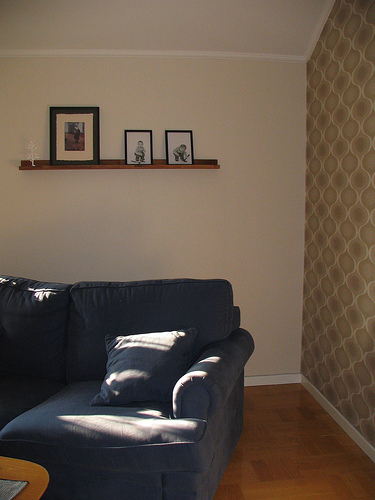

[[20551, 'sofa', 0.5447306632995605],
 [44220, 'sofas', 0.9374755024909973],
 [51850, 'comfy', 1.009480357170105],
 [53282, 'upholstered', 1.02677321434021],
 [46613, 'lounging', 1.1114754676818848],
 [22958, 'patio', 1.1382684707641602],
 [24406, 'mattress', 1.1463510990142822],
 [14069, 'velvet', 1.1678975820541382],
 [41298, 'carpeting', 1.1687672138214111],
 [24298, 'plush', 1.1700618267059326]]

In [27]:
get_image_labels(image_paths[223], display_image=True)

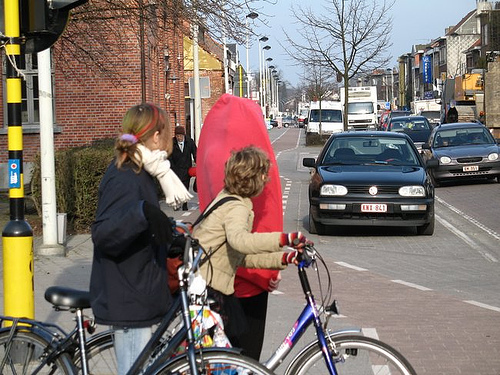

[[8433, 'bicycle', 0.5204640030860901],
 [7213, 'motorcycle', 0.7902948260307312],
 [7018, 'taxi', 1.0085076093673706],
 [1708, 'bus', 1.0097938776016235],
 [11142, 'cab', 1.1509723663330078],
 [7611, 'garage', 1.1546021699905396],
 [5837, 'subway', 1.1708734035491943],
 [12796, 'sidewalk', 1.1883164644241333],
 [5083, 'metro', 1.2043559551239014],
 [3036, 'circuit', 1.2063475847244263]]

In [28]:
get_image_labels(image_paths[363], display_image=True)

*Searching for specific category/label:*

In [46]:
search_by_text("aeroplane") # plane

,
,
,
,
,


*Searching for categories that are not in image dataset:*

In [47]:
search_by_text("avian") # birds

,
,
,
,
,


In [48]:
search_by_text("ocean")

,
,
,
,
,


In [49]:
search_by_text("street")

,
,
,
,
,


*Achieving more complex queries by combining words:*

In [50]:
search_by_text("horse jockey")

,
,
,
,
,


In [51]:
search_by_text("bird near water")

,
,
,
,
,


*Since we are able to identify labels on an image, we can perform search by image:*

In [52]:
search_similar_images(image_paths[650])

,
,
,
,
,


In [53]:
search_similar_images(image_paths[711])

,
,
,
,
,


*The same goes for images outside of the dataset*

In [54]:
search_similar_images('./demo_images/modern-interior-design-home-preview.jpg')

,
,
,
,
,


In [55]:
search_similar_images('./demo_images/death-railway-4008940_960_720.jpg')

,
,
,
,
,


In [56]:
search_similar_images('./demo_images/moor-moorland-grasses-wetland-nature-conservation-nature-reserve-nature-landscape-wetlands.jpg')

,
,
,
,
,


In [57]:
search_by_text("fence")

,
,
,
,
,


In [58]:
search_by_text("sky")

,
,
,
,
,


In [59]:
search_by_text("snow")

,
,
,
,
,


But...

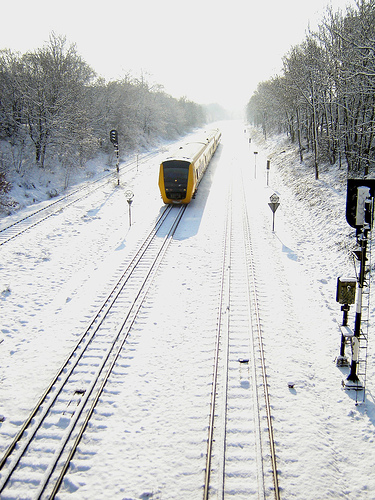

In [66]:
display(Image(filename="./dataset/train/2008_004914.jpg"))

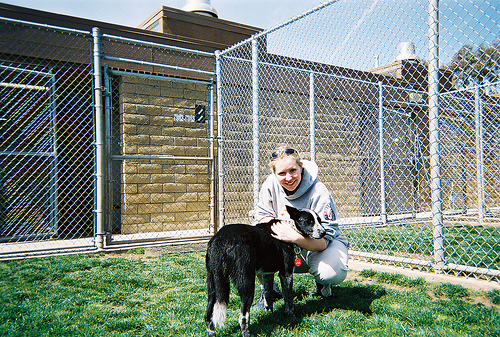

In [65]:
display(Image(filename="./dataset/dog/2008_000620.jpg"))

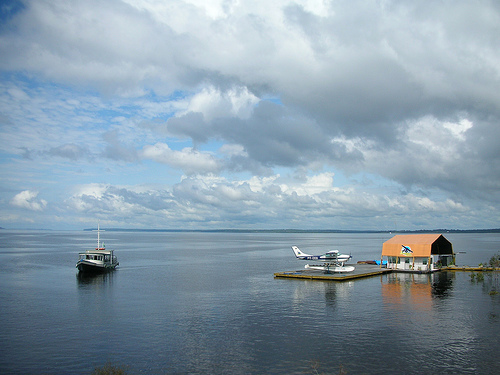

In [67]:
display(Image(filename="./dataset/aeroplane/2008_003275.jpg"))